<a href="https://colab.research.google.com/github/amolprabhu/NYC-Taxi-Duration-Prediction/blob/main/NYC_Taxi_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction to the problem**

### Everyone in this whole wide world has heard about the very famous New York City. A city of dreams, a city of ambitions and a city that everyone wants to visit once in a life time. 

### Like any other famous metropolitans in the world which are filled with taxis and other forms of transportation, New York is no different in this fact. It is bustling with activity and filled with cars and taxis trying to get to some destination.

### Well, this is what a normal person would see, but would a Data Scientist see the same? NO! We as data scientists look to find meaning behind activities, combine them with numbers and gain important information which normally, people cannot not fathom.

### So here we are, analyzing the busy taxis of New York city with the main goal being, to predict the trip duration given a bunch of other factors. Sounds interesting isn't it?

## <b> Problem Description </b>

### So our main goal here is to predict the total trip duration of taxis in New York City. The data which we have is released by the NYC Taxi and Limousine Commission (TLC). It includes various features related to the taxi trips.


## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

## **Starting off with the project**

###So we have the data, we know what the variables mean. Let us now go ahead and apply our knowledge.

###The project is mainly done in 4 phases

###1. Data Cleaning and Feature Engineering
###2. Exploratory Data Analysis
###3. Model Building and Evaluation
###4. Model Tuning 

## **1. Data Cleaning and Feature Engineering**

In [7]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [8]:
# Importing the necessary data
data = pd.read_csv('/content/drive/MyDrive/NYC Taxi/NYC Taxi Data.csv')

In [9]:
# Viewing the first 5 rows of the data
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [10]:
# Understanding the statistics of the columns
data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [11]:
# Brief description of the columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [12]:
# Checking for null values
data.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [13]:
# Dropping the 'id' column
data.drop('id', axis = 1, inplace = True)

In [14]:
# Understanding the 'vendor id' column
data['vendor_id'].value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

In [15]:
# Unique items of 'passenger count'
data['passenger_count'].unique()

array([1, 6, 4, 2, 3, 5, 0, 7, 9, 8])

In [16]:
# Number of empty trips or trips with no passengers
len(data[data['passenger_count'] == 0])

60

In [17]:
# Dropping rows with empty passenger count
data.drop(data[data['passenger_count'] == 0].index, axis = 0, inplace= True)

In [18]:
# Importing datatime to help conversion of string to datetime
from datetime import datetime

In [72]:
# Creating a function to convert string to datetime
def str_to_datetime(rows):
  ''' Converts string variable to datetime variable'''
  d = datetime.strptime(rows, '%Y-%m-%d %H:%M:%S')
  return d

In [20]:
# Applying the function to columns
data['dropoff_datetime'] = data['dropoff_datetime'].apply(str_to_datetime)
data['pickup_datetime'] = data['pickup_datetime'].apply(str_to_datetime)

In [21]:
# Creating new columns using pickup date and time
data['trip_month'] = data['pickup_datetime'].dt.month
data['trip_date'] = data['pickup_datetime'].dt.day
data['trip_day_of_week'] = data['pickup_datetime'].dt.dayofweek
data['trip_hour'] = data['pickup_datetime'].dt.hour

   Boundaries of New York City 
   
    "name": "New York",
    "min_lat": 40.4772,
    "max_lat": 45.0153,
    "min_lng": -79.7624,
    "max_lng": -71.7517



In [23]:
# Filtering the locations which fall into the boundaries of New York City
data = data[(data['pickup_longitude'] >= -79.7624) & (data['pickup_longitude'] <=  -71.7517)]
data = data[(data['pickup_latitude'] >= 40.4772) & (data['pickup_latitude'] <= 45.0153 )]
data = data[(data['dropoff_longitude'] >= -79.7624) & (data['dropoff_longitude'] <= -71.7517 )]
data = data[(data['dropoff_latitude'] >= 40.4772) & (data['dropoff_latitude'] <= 45.0153 )]

In [24]:
# Printing maximum and minimum, longitude and latitude to check if data lies within boundaries
print('--'*5 + ' ' + ' pickup longitude and latitude' + ' ' + '--'*5)
print(max(data['pickup_longitude']))
print(max(data['pickup_latitude']))
print(min(data['pickup_longitude']))
print(min(data['pickup_latitude']))

print('--'*5 + ' ' + ' dropoff longitude and latitude' + ' ' + '--'*5)
print(max(data['dropoff_longitude']))
print(max(data['dropoff_latitude']))
print(min(data['dropoff_longitude']))
print(min(data['dropoff_latitude']))

----------  pickup longitude and latitude ----------
-71.88164520263672
43.91176223754883
-79.48789978027342
40.49589538574219
----------  dropoff longitude and latitude ----------
-71.88164520263672
43.92102813720703
-79.55353546142578
40.47971725463867


In [25]:
# Installing haversine package
!pip install haversine

In [26]:
# Importing haversine
import haversine as hs

In [27]:
# Creating new columns by combining columns
data['pickup_point'] = list(zip(data['pickup_latitude'], data['pickup_longitude']))
data['dropoff_point'] = list(zip(data['dropoff_latitude'], data['dropoff_longitude']))
data['points'] = list(zip(data['pickup_point'],data['dropoff_point']))

In [71]:
# Creating a function that returns distance between 2 points
def distance(rows):
  ''' Calculates haversine disatnce between 2 point '''
  kms = hs.haversine(rows[0],rows[1])
  return kms  

In [29]:
# New column showing distance between 2 points and rounding of distance to eliminate miniscule distances
data['trip_distance'] = round(data['points'].apply(distance))

In [30]:
# Number of entries with no distance
len(data[data['trip_distance'] == 0])

48825

In [31]:
# Removing the observations with 0 distance, assuming that there was no movement
data.drop(data[data['trip_distance'] == 0].index, axis=0, inplace=True)

In [32]:
# Creating a dataframe with dummy variables for 'store and fwd flag' column
flag_df = pd.get_dummies(data= data['store_and_fwd_flag'], prefix = 'store_and_fwd_flag')

In [33]:
# Concatenating flag_df to original data
data = pd.concat([data,flag_df], axis =1)

In [34]:
# Adding a column of speed to get get meaningful combinaitons of distance and speed
data['speed_km/h'] = data['trip_distance'] / (data['trip_duration']/3600)

In [35]:
# Setting a speed ranging from 10 km/h to 60 km/hr
data = data[(data['speed_km/h'] >= 10 ) & (data['speed_km/h'] <= 60)]

In [36]:
# Description on the data after cleaning and adding features
data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,trip_month,trip_date,trip_day_of_week,trip_hour,trip_distance,store_and_fwd_flag_N,store_and_fwd_flag_Y,speed_km/h
count,996127.000000,996127.000000,996127.000000,996127.000000,996127.000000,996127.000000,996127.000000,996127.000000,996127.000000,996127.000000,996127.000000,996127.000000,996127.000000,996127.000000,996127.000000
mean,1.535859,1.663288,-73.970240,40.750382,-73.970147,40.752007,836.677847,3.480268,15.497625,3.138063,13.468966,4.286686,0.994349,0.005651,18.052210
std,0.498713,1.312525,0.043224,0.030527,0.040418,0.036122,692.591390,1.678997,8.717991,2.012129,6.868489,4.425620,0.074960,0.074960,7.332883
min,1.000000,1.000000,-74.332397,40.525059,-74.728508,40.479717,60.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,10.000000
25%,1.000000,1.000000,-73.991707,40.735542,-73.990997,40.733555,345.000000,2.000000,8.000000,1.000000,8.000000,2.000000,1.000000,0.000000,12.720848
50%,2.000000,1.000000,-73.981087,40.754639,-73.978050,40.755211,639.000000,3.000000,15.000000,3.000000,14.000000,3.000000,1.000000,0.000000,16.000000
75%,2.000000,2.000000,-73.964867,40.769764,-73.958405,40.773697,1069.000000,5.000000,23.000000,5.000000,20.000000,5.000000,1.000000,0.000000,21.114370
max,2.000000,6.000000,-73.237999,41.157372,-72.711395,41.421406,10965.000000,6.000000,31.000000,6.000000,23.000000,116.000000,1.000000,1.000000,60.000000


## **2. Exploratory Data Analysis**

### After adding features and cleaning the data, we now can go ahead and analyse the variables with the help of various charts. 

## **Univariate Analysis**

In [37]:
# Setting gridlines style
sns.set_style('whitegrid')

Text(0, 0.5, 'Count of Vendor ID')

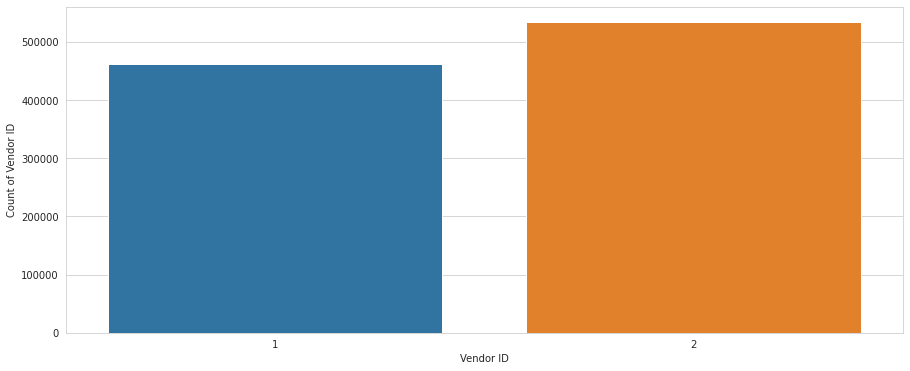

In [38]:
# Understanding the contribution of vendors
plt.figure(figsize = (15,6))
sns.countplot(data['vendor_id'])
plt.xlabel('Vendor ID')
plt.ylabel('Count of Vendor ID')

Text(0, 0.5, 'Count of Trips')

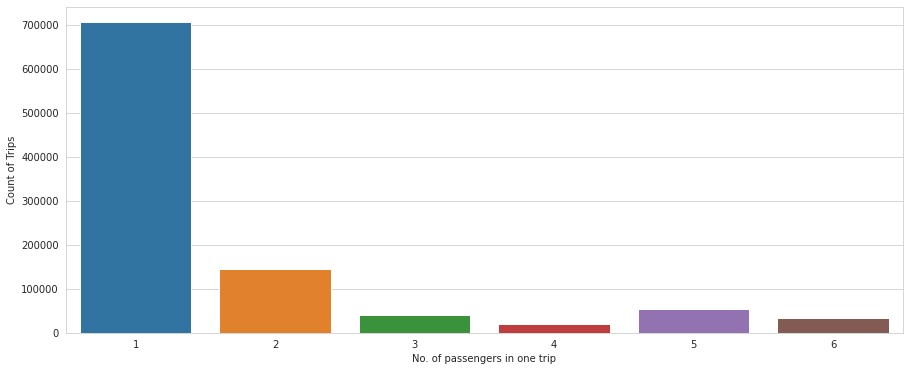

In [39]:
# Different no. of passengers in the trip
plt.figure(figsize = (15,6))
sns.countplot(data['passenger_count'])
plt.xlabel('No. of passengers in one trip')
plt.ylabel('Count of Trips')

Text(0.5, 0, 'Passenger Count')

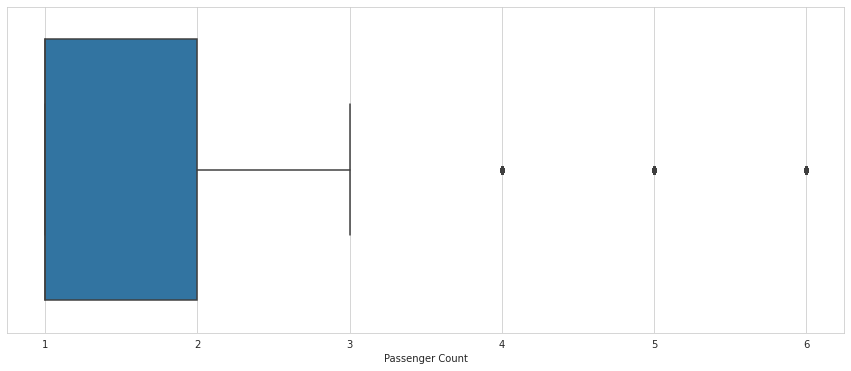

In [40]:
# Distribution of the passengers
plt.figure(figsize = (15,6))
sns.boxplot(data['passenger_count'])
plt.xlabel('Passenger Count')

Text(0, 0.5, 'Count of Store and Forward flag')

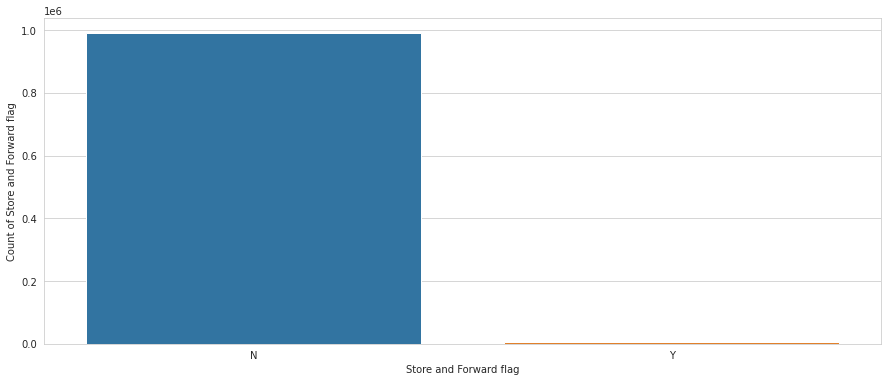

In [41]:
# Count of store and forward flag 
plt.figure(figsize = (15,6))
sns.countplot(data['store_and_fwd_flag'])
plt.xlabel('Store and Forward flag')
plt.ylabel('Count of Store and Forward flag')


Text(0.5, 0, 'Trip Duration (in seconds)')

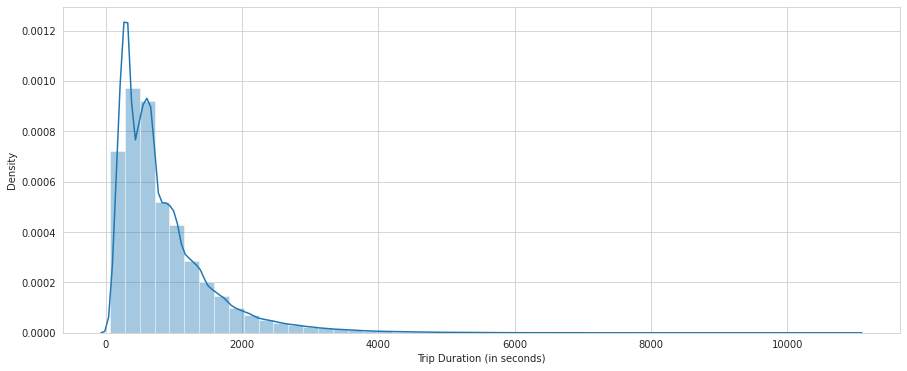

In [42]:
# Distribution of trip duration
plt.figure(figsize = (15,6))
sns.distplot(data['trip_duration'])
plt.xlabel('Trip Duration (in seconds)')

Text(0.5, 0, 'Trip Duration (in seconds)')

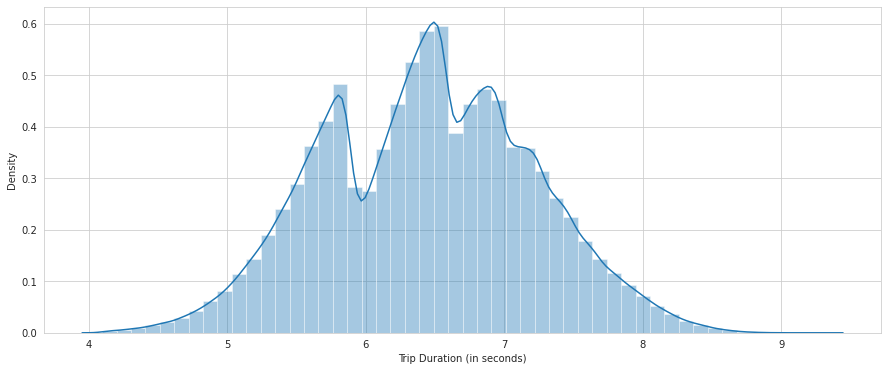

In [43]:
# As dependent variable is highly positively skewed, log transformation is done
plt.figure(figsize = (15,6))
sns.distplot(np.log(data['trip_duration']))
plt.xlabel('Trip Duration (in seconds)')

In [44]:
# Creating a column after log transformation of the trip duration
data['log_duration'] = np.log(data['trip_duration'])

Text(0, 0.5, 'Count of Trips')

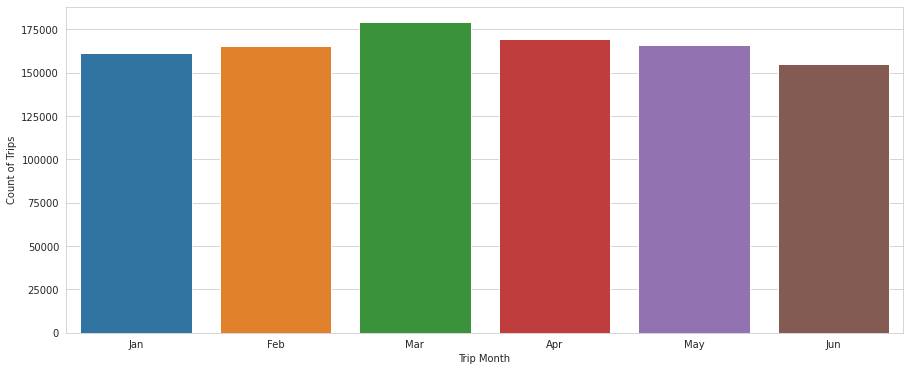

In [45]:
# No. of trips taken in different months of the year
plt.figure(figsize = (15,6))
ax = plt.axes()
sns.countplot(data['trip_month'])
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun'])
plt.xlabel('Trip Month')
plt.ylabel('Count of Trips')

Text(0, 0.5, 'Count of Trips')

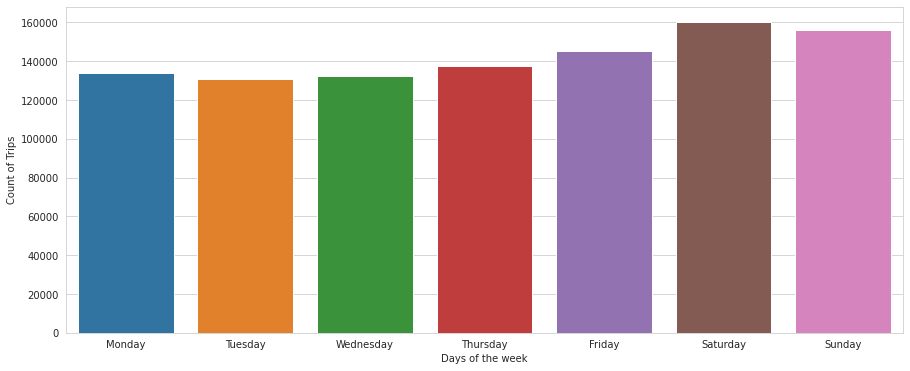

In [46]:
# Trips taken on different days of the week from Monday to Sunday
plt.figure(figsize = (15,6))
ax = plt.axes()
sns.countplot(data['trip_day_of_week'])
ax.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.xlabel('Days of the week')
plt.ylabel('Count of Trips')

Text(0, 0.5, 'Count of Trips')

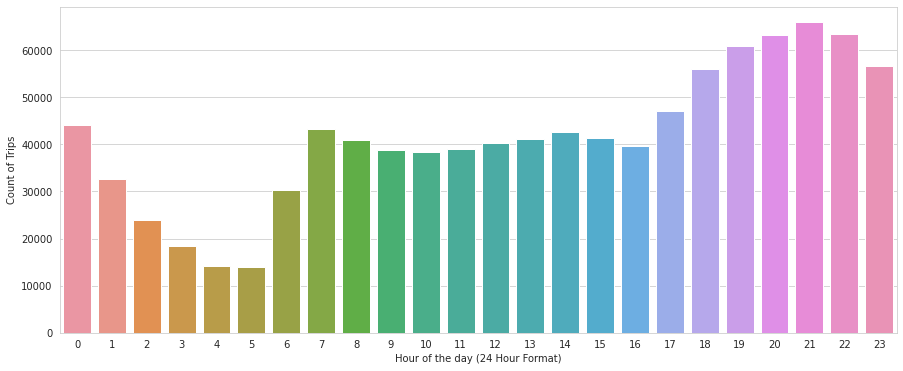

In [47]:
# Taxi trips taken in different hours of the day staring from 12 AM to 11 PM
plt.figure(figsize = (15,6))
sns.countplot(data['trip_hour'])
plt.xlabel('Hour of the day (24 Hour Format)')
plt.ylabel('Count of Trips')

Text(0.5, 0, 'Trip Distance (in kilometers)')

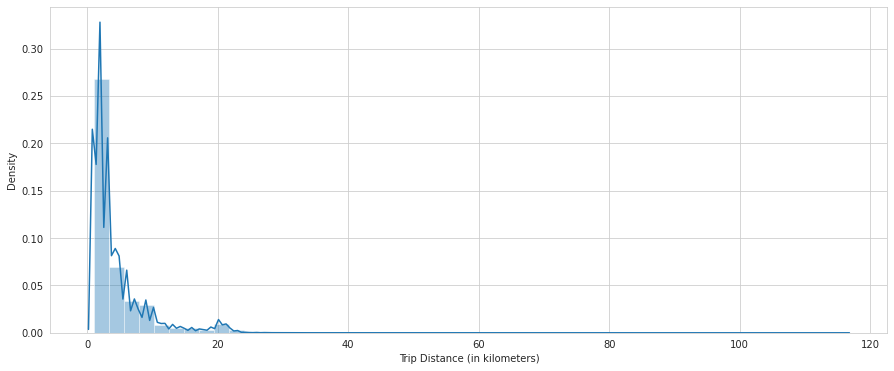

In [48]:
# Distribution of trip distances
plt.figure(figsize = (15,6))
sns.distplot(data['trip_distance'])
plt.xlabel('Trip Distance (in kilometers)')

Text(0.5, 0, 'Speed (in km/h)')

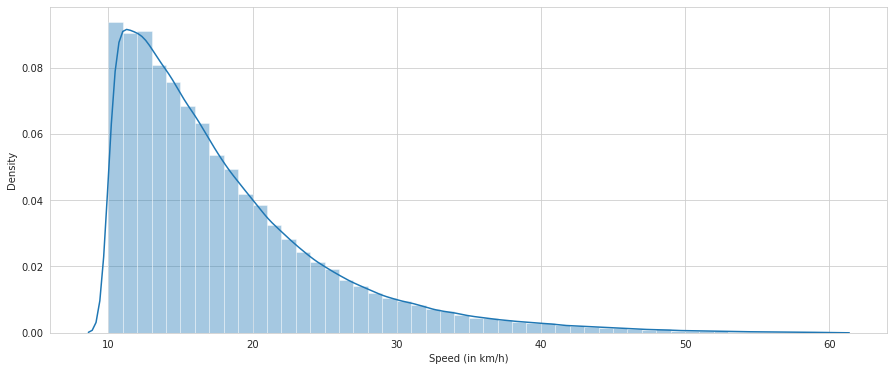

In [49]:
# Distribution of speed ranging from 10 km/h to 60 km/h as filtered previously
plt.figure(figsize = (15,6))
sns.distplot(data['speed_km/h'])
plt.xlabel('Speed (in km/h)')

## **Bivariate Analysis** 

Text(0, 0.5, 'Speed (in km/h)')

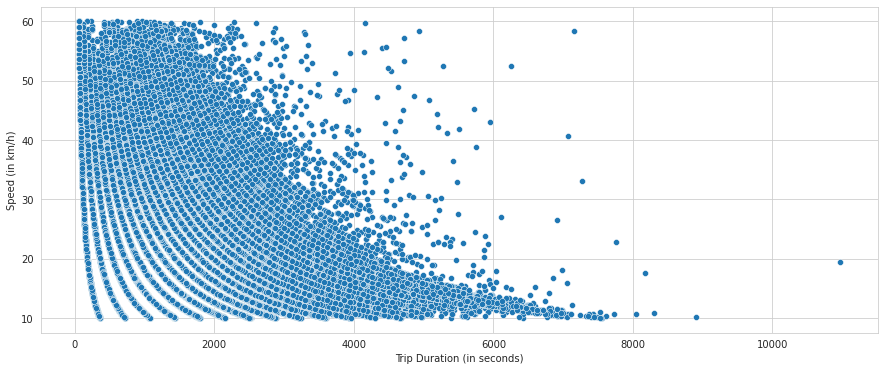

In [50]:
# Scatter plot explaining the realtion between trip duration and speed
plt.figure(figsize = (15,6))
sns.scatterplot(x = data['trip_duration'], y = data['speed_km/h'])
plt.xlabel('Trip Duration (in seconds)')
plt.ylabel('Speed (in km/h)')

Text(0, 0.5, 'Trip Distance (in kilometers)')

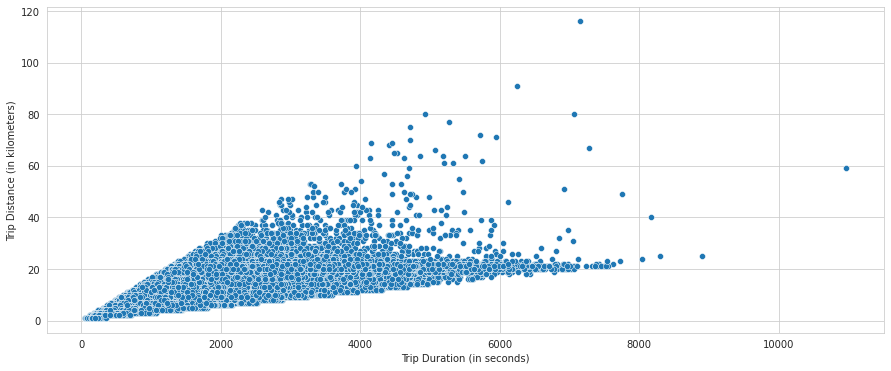

In [51]:
# Scatter plot explaining the relation between trip duration and distance
plt.figure(figsize = (15,6))
sns.scatterplot(x = data['trip_duration'], y = data['trip_distance'])
plt.xlabel('Trip Duration (in seconds)')
plt.ylabel('Trip Distance (in kilometers)')

Text(0, 0.5, 'Average trip duration per day')

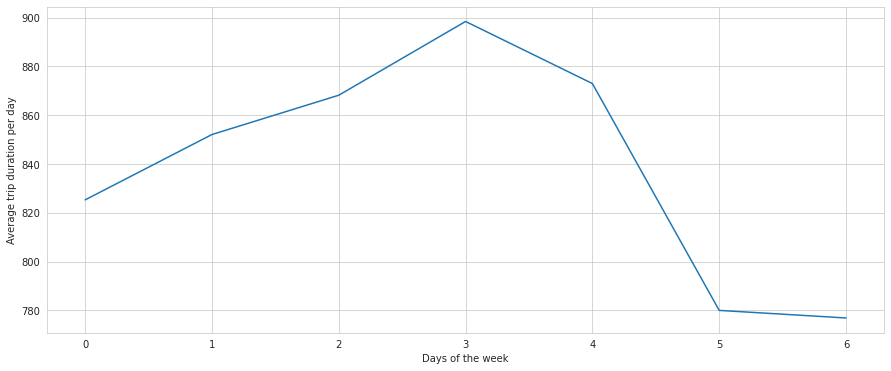

In [52]:
# Line Graph depicting relation between day of the week and mean travel time
plt.figure(figsize=(15,6))
plt.plot(data.groupby('trip_day_of_week').mean()['trip_duration'])
plt.xlabel('Days of the week')
plt.ylabel('Average trip duration per day')

Text(0, 0.5, 'Total trip distance per day (in kilometers)')

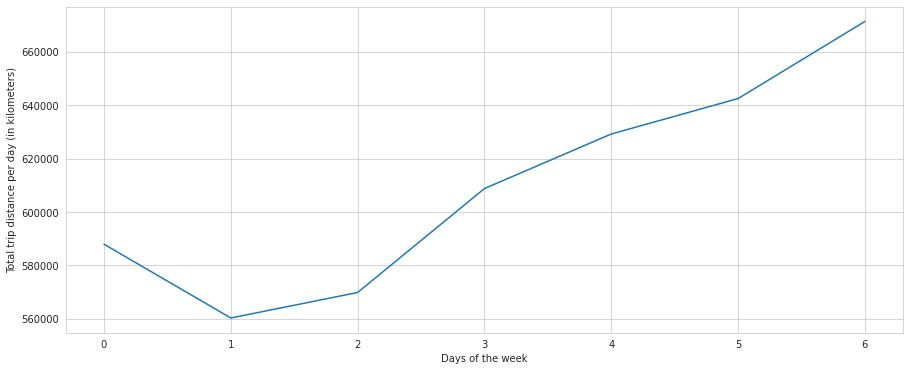

In [53]:
# Line graph showing relation between day of week and total trip distance per day
plt.figure(figsize=(15,6))
plt.plot(data.groupby('trip_day_of_week').sum()['trip_distance'])
plt.xlabel('Days of the week')
plt.ylabel('Total trip distance per day (in kilometers)')

Text(0, 0.5, 'Average trip duration per month (in seconds)')

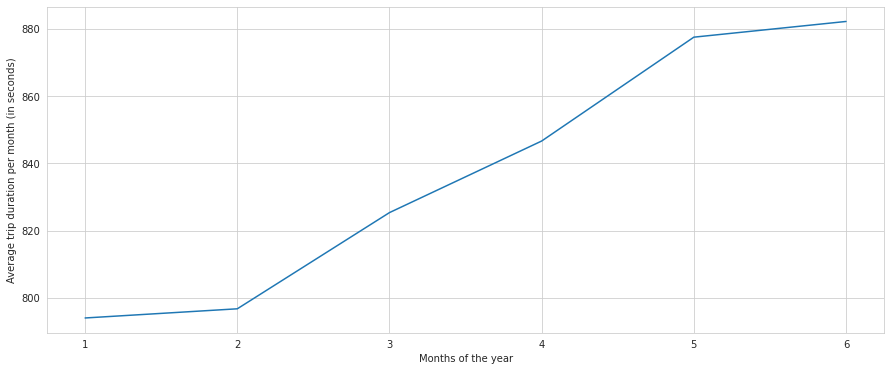

In [54]:
# Line graph showing relation between month and avearge single trip duration per month
plt.figure(figsize=(15,6))
plt.plot(data.groupby('trip_month').mean()['trip_duration'])
plt.xlabel('Months of the year')
plt.ylabel('Average trip duration per month (in seconds)')

Text(0, 0.5, 'Total passengers per day of week')

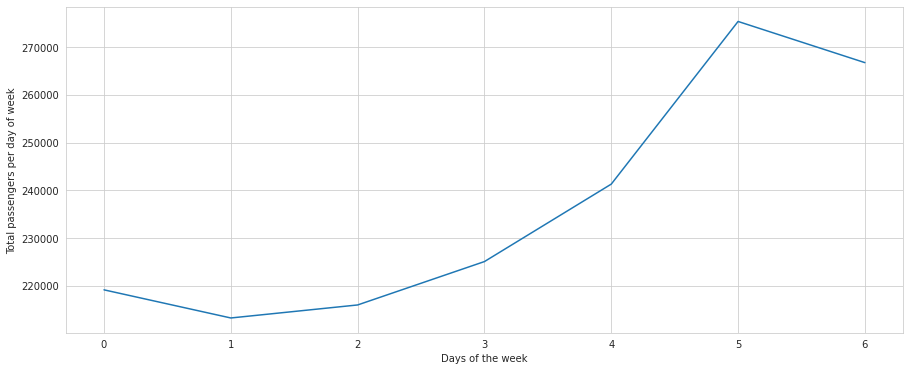

In [55]:
# Line graph depicting realtion between day of week and counts of passengers
plt.figure(figsize=(15,6))
plt.plot(data.groupby('trip_day_of_week').sum()['passenger_count'])
plt.xlabel('Days of the week')
plt.ylabel('Total passengers per day of week')

Text(0, 0.5, 'Average speed (in km/h)')

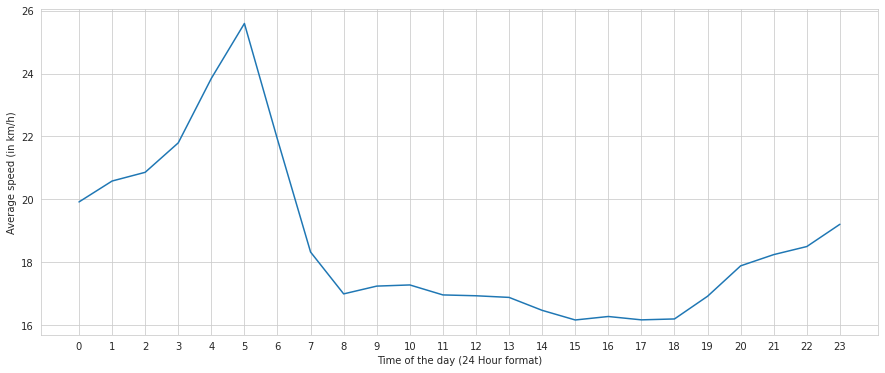

In [56]:
# Line Graph showing relation bewteen average speed and different time of the day
plt.figure(figsize=(15,6))
ax = plt.axes()
plt.plot(data.groupby('trip_hour').mean()['speed_km/h'])
ax.set_xticks(list(range(0,24)))
plt.xlabel('Time of the day (24 Hour format)')
plt.ylabel('Average speed (in km/h)')

In [57]:
# Description of the data
data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,trip_month,trip_date,trip_day_of_week,trip_hour,trip_distance,store_and_fwd_flag_N,store_and_fwd_flag_Y,speed_km/h,log_duration
count,996127.000000,996127.000000,996127.000000,996127.000000,996127.000000,996127.000000,996127.000000,996127.000000,996127.000000,996127.000000,996127.000000,996127.000000,996127.000000,996127.000000,996127.000000,996127.000000
mean,1.535859,1.663288,-73.970240,40.750382,-73.970147,40.752007,836.677847,3.480268,15.497625,3.138063,13.468966,4.286686,0.994349,0.005651,18.052210,6.443023
std,0.498713,1.312525,0.043224,0.030527,0.040418,0.036122,692.591390,1.678997,8.717991,2.012129,6.868489,4.425620,0.074960,0.074960,7.332883,0.763797
min,1.000000,1.000000,-74.332397,40.525059,-74.728508,40.479717,60.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,10.000000,4.094345
25%,1.000000,1.000000,-73.991707,40.735542,-73.990997,40.733555,345.000000,2.000000,8.000000,1.000000,8.000000,2.000000,1.000000,0.000000,12.720848,5.843544
50%,2.000000,1.000000,-73.981087,40.754639,-73.978050,40.755211,639.000000,3.000000,15.000000,3.000000,14.000000,3.000000,1.000000,0.000000,16.000000,6.459904
75%,2.000000,2.000000,-73.964867,40.769764,-73.958405,40.773697,1069.000000,5.000000,23.000000,5.000000,20.000000,5.000000,1.000000,0.000000,21.114370,6.974479
max,2.000000,6.000000,-73.237999,41.157372,-72.711395,41.421406,10965.000000,6.000000,31.000000,6.000000,23.000000,116.000000,1.000000,1.000000,60.000000,9.302464


In [58]:
# Extracting columns to use for modelling
columns_to_use = ['vendor_id','passenger_count','pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude','trip_month','trip_date', 'trip_day_of_week', 'trip_hour','trip_distance', 'store_and_fwd_flag_N',
       'store_and_fwd_flag_Y', 'log_duration']

In [59]:
# Creating a dataframe containing final features
final_df = data[columns_to_use]

In [54]:
# First 5 rows of the new dataframe
final_df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_month,trip_date,trip_day_of_week,trip_hour,trip_distance,store_and_fwd_flag_N,store_and_fwd_flag_Y,log_duration
1,1,1,-73.980415,40.738564,-73.999481,40.731152,6,12,6,0,2.0,1,0,6.496775
2,2,1,-73.979027,40.763939,-74.005333,40.710087,1,19,1,11,6.0,1,0,7.661056
6,1,4,-73.969017,40.757839,-73.957405,40.765896,6,17,4,22,1.0,1,0,5.831882
7,2,1,-73.969276,40.797779,-73.922470,40.760559,5,21,5,7,6.0,1,0,7.346655
8,1,1,-73.999481,40.738400,-73.985786,40.732815,5,27,4,23,1.0,1,0,5.541264


## **3. Model Building**

### As we can understand from the dependent variable that this is a regression problem. I have chosen to go with a decision tree. I have further used ensembling techniques to improve the model.

In [3]:
# Importing all necessary libraries for a regression model
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
# Creating instances of different models
dt = DecisionTreeRegressor()
rf = RandomForestRegressor(n_estimators=50)
gbr = GradientBoostingRegressor()
xgr = XGBRegressor()

In [60]:
# Splitting the dataframe into independent and dependent variables
X = final_df.iloc[:,:-1]
y = final_df['log_duration']

In [61]:
# Shape of the independent and dependent variables
print(X.shape)
print(y.shape)

(996127, 13)
(996127,)


In [62]:
# Dividing the independent and dependent variables into training and testing groups
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.2)

In [60]:
# Shape of each group
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(796901, 13)
(199226, 13)
(796901,)
(199226,)


* ## **Decision Tree**







In [61]:
dt.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [62]:
dt_preds = dt.predict(X_test)
dt_train_preds = dt.predict(X_train)

In [63]:
def adjusted_r2(r2_score):
  a_r2 = 1 - (((1-r2_score) * (len(y)-1))/(len(y)-X.shape[1]-1))
  return a_r2

In [64]:
print('--'*10 + 'Decision Tree' + '--'*10)
print(f'RMSE for train data is : {np.sqrt(mean_squared_error(y_train, dt_train_preds))}')
print(f'RMSE for test data is : {np.sqrt(mean_squared_error(y_test, dt_preds))}')
print(f'r2 score for train data is : {r2_score(y_train, dt_train_preds)}')
print(f'r2 score for test data is : {r2_score(y_test, dt_preds)}')

--------------------Decision Tree--------------------
RMSE for train data is : 9.069802740810407e-06
RMSE for test data is : 0.3260150044363
r2 score for train data is : 0.9999999998590093
r2 score for test data is : 0.8177274695508714


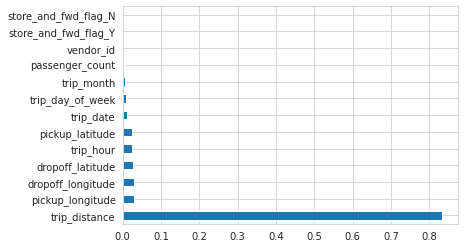

In [65]:
feat_importances = pd.Series(dt.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

* ## **Random Forest**


In [66]:
# Fitting the data into the random forest model
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [67]:
# Predicting values
rf_preds = rf.predict(X_test)
rf_train_preds = rf.predict(X_train)

In [68]:
# Evaluation metrics for the random forest model
print('--'*10 + 'Random Forest' + '--'*10)
print(f'RMSE for train data is : {np.sqrt(mean_squared_error(y_train, rf_train_preds))}')
print(f'RMSE for test data is : {np.sqrt(mean_squared_error(y_test, rf_preds))}')
print(f'r2 score for train data is : {r2_score(y_train, rf_train_preds)}')
print(f'r2 score for test data is : {r2_score(y_test, rf_preds)}')

--------------------Random Forest--------------------
RMSE for train data is : 0.08725229498355119
RMSE for test data is : 0.22885095768822386
r2 score for train data is : 0.9869518635821268
r2 score for test data is : 0.9101844539884814


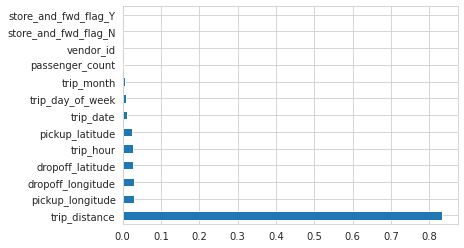

In [69]:
# Feature importances for the random forest model
feat_importances_rf = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances_rf.nlargest(20).plot(kind='barh')

* ## **Gradient Boosting**

In [70]:
# Fitting data into the gradient boosting model
gbr.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [71]:
# Predicting values using the gradient boosting model
gbr_preds = gbr.predict(X_test)
gbr_train_preds = gbr.predict(X_train)

In [72]:
# Evaluation metrics of the gradient boosting model
print('--'*10 + 'Gradient Boosting' + '--'*10)
print(f'RMSE for train data is : {np.sqrt(mean_squared_error(y_train, gbr_train_preds))}')
print(f'RMSE for test data is : {np.sqrt(mean_squared_error(y_test, gbr_preds))}')
print(f'r2 score for train data is : {r2_score(y_train, gbr_train_preds)}')
print(f'r2 score for test data is : {r2_score(y_test, gbr_preds)}')

--------------------Gradient Boosting--------------------
RMSE for train data is : 0.2819623959856205
RMSE for test data is : 0.2817815104829239
r2 score for train data is : 0.8637372481460092
r2 score for test data is : 0.8638332626167505


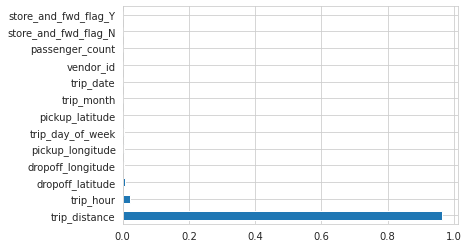

In [73]:
# Feature importances of the gradient boosting model
feat_importances_gbr = pd.Series(gbr.feature_importances_, index=X.columns)
feat_importances_gbr.nlargest(20).plot(kind='barh')

* ## **XGBoost Regressor**

In [74]:
# Fitting data to the XGBoost Regressor model
xgr.fit(X_train,y_train)

[08:55:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [75]:
# Predicting values using the XGBoost Regressor model
xgr_preds = xgr.predict(X_test)
xgr_train_preds = xgr.predict(X_train)

In [76]:
# Evaluation metrics of the XGBoost Regressor model
print('--'*10 + 'XGB Regressor' + '--'*10)
print(f'RMSE for train data is : {np.sqrt(mean_squared_error(y_train, xgr_train_preds))}')
print(f'RMSE for test data is : {np.sqrt(mean_squared_error(y_test, xgr_preds))}')
print(f'r2 score for train data is : {r2_score(y_train, xgr_train_preds)}')
print(f'r2 score for test data is : {r2_score(y_test, xgr_preds)}')

--------------------XGB Regressor--------------------
RMSE for train data is : 0.28167803390903184
RMSE for test data is : 0.28147208391128886
r2 score for train data is : 0.864011954424334
r2 score for test data is : 0.8641321500279132


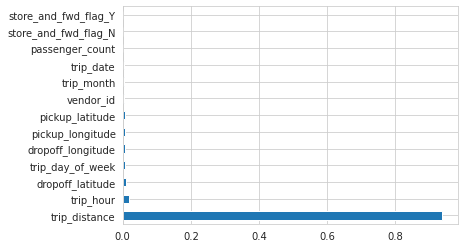

In [77]:
# Feature importances of the XGBoost Regressor model
feat_importances_xgr = pd.Series(xgr.feature_importances_, index=X.columns)
feat_importances_xgr.nlargest(20).plot(kind='barh')

### From the above model building and evaluation section we can undersatnd some key things 

* ### Decision Tree is overfitting.
* ### Random forest is doing a better job than other models.
* ### XGB Regressor and Gradient Boosting models are giving similar results
* ### Random forest is computationally more expensive but is considering more features.

### As of now our choice would be to go for a Random Forest model.



## **4. Hyperparameter Tuning**

### In this section we will try to fine tune our models by tweaking the hyperparameters. For this we will choose the 2 best models, XGB Regressor and Random Forest

## **XGB Regressor hyperparameter tuning**

In [78]:
# Parameters for hyperparameter tuning
param_dict = {'max_depth' : [3,5,10],
              'learning_rate': [0.4,0.6],
              'n_estimators' : [120,140]}

In [79]:
# Creating an instance of the GridSearch
xgr_grid_search = GridSearchCV(estimator= xgr, param_grid= param_dict, cv = 3)

In [80]:
# Fitting the model
xgr_grid_search.fit(X_train,y_train)

[08:56:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:56:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:57:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:57:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:58:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:59:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:01:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.4, 0.6], 'max_depth': [3, 5, 10],
                         'n_estimators': [120, 140]},

In [81]:
# The best estimator with optimum parameters
xgr_grid_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.4, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=140,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [82]:
# Creating an instance of the best estimator
xgr_best_model = xgr_grid_search.best_estimator_

In [83]:
# Predicting using the best estimator
xgr_best_model_train_preds = xgr_best_model.predict(X_train)
xgr_best_model_test_preds = xgr_best_model.predict(X_test)

In [84]:
# Evaluation metrics of the XGBoost Regressor model after hyperparameter tuning
print('--'*10 + 'XGB Regressor with hyperparameter tuning' + '--'*10)
print(f'RMSE for train data is : {np.sqrt(mean_squared_error(y_train, xgr_best_model_train_preds))}')
print(f'RMSE for test data is : {np.sqrt(mean_squared_error(y_test, xgr_best_model_test_preds))}')
print(f'r2 score for train data is : {r2_score(y_train, xgr_best_model_train_preds)}')
print(f'r2 score for test data is : {r2_score(y_test, xgr_best_model_test_preds)}')

--------------------XGB Regressor with hyperparameter tuning--------------------
RMSE for train data is : 0.17833040894878405
RMSE for test data is : 0.2199104111004795
r2 score for train data is : 0.9454938406353761
r2 score for test data is : 0.917065042415389


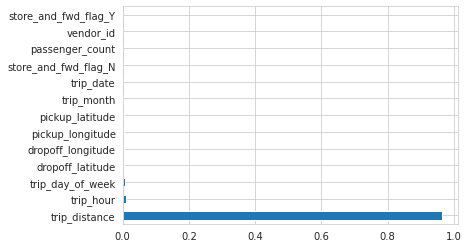

In [85]:
# Feature importances of the best estimator
feat_importances_xgr_best = pd.Series(xgr_best_model.feature_importances_, index=X.columns)
feat_importances_xgr_best.nlargest(20).plot(kind='barh')

## **Random Forest hyperparameter tuning**

In [63]:
# Random forest hyperparameter tuning
rf_param_dict = {'n_estimators' : [60,80]}

In [64]:
# Creating an instance for GridSearchCV for random forest
rf_best_model = GridSearchCV(estimator=rf, param_grid=rf_param_dict, cv=3, n_jobs=-1, verbose=2)

In [65]:
# Fitting into the random forest model with best hyperparameters
rf_best_model.fit(X_train,y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 27.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=50, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_job

In [66]:
# Best model parameters for random forest
rf_best_model.best_params_   

{'n_estimators': 80}

In [67]:
# Creating an instance of the random forest model with the best estimators
rf_best = rf_best_model.best_estimator_

In [68]:
# Predicting the model using the best estimators
rf_best_train_preds = rf_best.predict(X_train)
rf_best_test_preds = rf_best.predict(X_test)

In [69]:
# Evaluation metrics for random forest after hyperparameter tuning
print('--'*10 + 'Random Forest with hyperparameter tuning' + '--'*10)
print(f'RMSE for train data is : {np.sqrt(mean_squared_error(y_train, rf_best_train_preds))}')
print(f'RMSE for test data is : {np.sqrt(mean_squared_error(y_test, rf_best_test_preds))}')
print(f'r2 score for train data is : {r2_score(y_train, rf_best_train_preds)}')
print(f'r2 score for test data is : {r2_score(y_test, rf_best_test_preds)}')

--------------------Random Forest with hyperparameter tuning--------------------
RMSE for train data is : 0.08578403189720486
RMSE for test data is : 0.2271452012549775
r2 score for train data is : 0.9873835424488463
r2 score for test data is : 0.9116239938873824


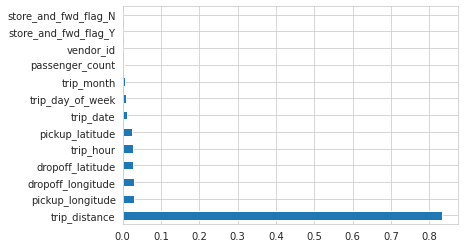

In [70]:
# Feature importances of the best estimator
feat_importances_rf_best = pd.Series(rf_best.feature_importances_, index=X.columns)
feat_importances_rf_best.nlargest(20).plot(kind='barh')

### From the hyperparameter tuning section we now come to understand that, tuning both the models is time consuming and needs more computational power.

* ### Random forest continues to give importances to more features as compared to XGB Regressor
* ### Random Forest is providing results similar to that of XGB Regressor.
* ### Random Forest with more n_estimators can perform better but will require more computational power.

## **CONCLUSION**



### In conclusion, this project has helped me analyse the various aspects of New York Taxis, helped me connect geography with a subject of data science.

### According to me, I would choose the Random Forest model as it consistently predicts the dependent variable before and definitely after the tuning as well. It also takes into consideration more features which would give a better decision. It has performed better with one hyperparameter tuning compared to 3 in the XGB Regressor. Hence, I would choose the Random Forest Model though they are a bit computationally expensive.

### There can be more features added such as weather and traffic data. Different models and hyperparameter tuning with vast range of hyperparamteres may even increase the model's performance.

### This particular project has helped me gain understanding in the whole process of a regression based problem. It has also made me crave to work deeper into this field.